#1. Análisis Exploratorio

# 1.1. Importación de librerias y dataset

In [224]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, accuracy_score, precision_score, roc_auc_score
from xgboost import plot_tree

In [225]:
# Las siguientes lineas de código comentadas sirven para convertir el archivo excel a uno csv y leerlo
read_file = pd.read_excel("BBDD_Hospitalización.xlsx")
read_file.to_csv(r'BBDD_Hospitalización.csv', index=None, header=True)
df = read_file = pd.read_csv("BBDD_Hospitalización.csv")

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


# 1.2. Visualización del dataset

In [226]:
df.head(50)

,EDAD,DIABETES,HOSPITALIZACIÓN ULTIMO MES,PSA,BIOPSIAS PREVIAS,VOLUMEN PROSTATICO,ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS,NUMERO DE MUESTRAS TOMADAS,CUP,ENF. CRONICA PULMONAR OBSTRUCTIVA,BIOPSIA,NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA,FIEBRE,ITU,TIPO DE CULTIVO,AGENTE AISLADO,PATRON DE RESISTENCIA,HOSPITALIZACION,DIAS HOSPITALIZACION MQ,DIAS HOSPITALIZACIÓN UPC
0,53.0,NO,NO,4.00,NO,SI,FLUOROQUINOLONA_AMINOGLICOSIDO,12.0,NO,NO,NEG,1,SI,NO,NO,NO,NO,SI,2.0,0.0
1,56.0,NO,NO,7.70,NO,SI,FLUOROQUINOLONA_AMINOGLICOSIDO,12.0,NO,NO,NEG,1,SI,NO,NO,NO,NO,SI,5.0,0.0
2,57.0,NO,NO,29.00,SI,SI,FLUOROQUINOLONA_AMINOGLICOSIDO,24.0,NO,NO,NEG,1,SI,NO,HEMOCULTIVO,E.COLI,"AMPI R, CIPRO R, GENTA R, SULFA M R",SI,4.0,3.0
3,56.0,NO,NO,7.00,NO,SI,FLUOROQUINOLONA_AMINOGLICOSIDO,12.0,NO,NO,NEG,1,SI,NO,NO,NO,NO,SI,5.0,0.0
4,55.0,NO,NO,29.00,SI,SI,FLUOROQUINOLONA_AMINOGLICOSIDO,24.0,NO,NO,NEG,1,SI,NO,HEMOCULTIVO,E.COLI,NO,SI,4.0,3.0
5,55.0,SI,SI,4.00,NO,SI,FLUOROQUINOLONA_AMINOGLICOSIDO,12.0,NO,NO,NEG,2,NO,NO,NO,NO,NO,SI,3.0,0.0
6,53.0,NO,NO,7.00,NO,SI,FLUOROQUINOLONA_AMINOGLICOSIDO,12.0,NO,NO,NEG,2,SI,SI,UROCULTIVO,E.COLI,"RESISTENTE A AMPI, CIPRO Y GENTA",SI,3.0,0.0
7,67.0,NO,NO,6.20,NO,SI,FLUOROQUINOLONA_AMINOGLICOSIDO,12.0,NO,NO,NEG,2,SI,SI,HEMOCULTIVO Y UROCULTIVO,E.COLI,"RESISTENTE A AMPI, SULFA, CEFADROXILO, CEFUROX...",SI,2.0,0.0
8,69.0,NO,NO,6.00,NO,NO,FLUOROQUINOLONA_AMINOGLICOSIDO,12.0,NO,NO,NEG,2,SI,NO,NO,NO,NO,SI,4.0,0.0
9,44.0,NO,NO,NaN,NO,NO,FLUOROQUINOLONA_AMINOGLICOSIDO,12.0,NO,NO,NEG,2,SI,NO,NO,NO,NO,SI,3.0,0.0


# 1.3. Variables Categóricas

El Antibiótico más utilizado fue el Fluoroquinolona Aminoglicosido por lo cual la grafica muestra una distribución hacia la izquierda.

[None, None, None, None, None, None, None, None, None, None]

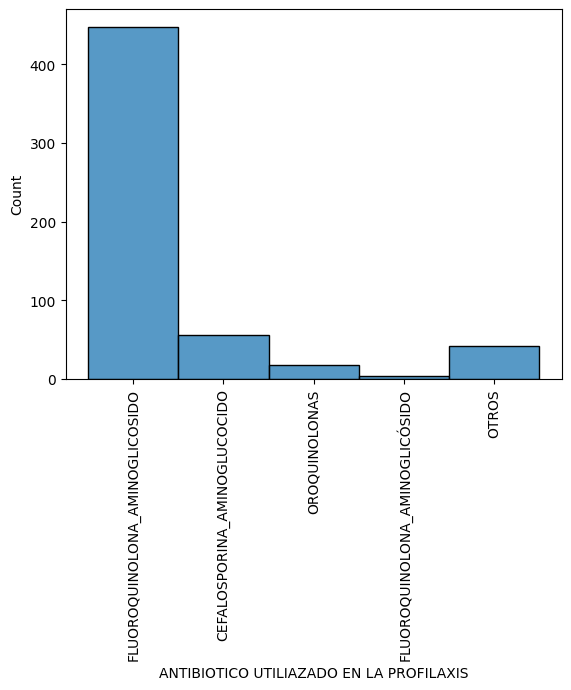

In [227]:
sns.histplot(data=df, x="ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

De la siguiente tabla pivote: Las infecciones más graves provienen de un promedio de edad mayor o igual a 62

In [228]:
pivot = df.pivot_table(index=['BIOPSIA'], values=['EDAD'])
print(pivot)

                                                 EDAD
BIOPSIA                                              
ADENOCARCINOMA GLEASON 10                   80.500000
ADENOCARCINOMA GLEASON 6                    68.750000
ADENOCARCINOMA GLEASON 6                    62.684211
ADENOCARCINOMA GLEASON 7                    69.600000
ADENOCARCINOMA GLEASON 7                    64.169811
ADENOCARCINOMA GLEASON 8                    70.954545
ADENOCARCINOMA GLEASON 9                    69.900000
CARCINOMA INDIFERENCIADO DE CELULAS CLARAS  81.000000
HIPERPLASIA PROSTATICA                      58.285714
NEG                                         62.760870
PROSTATITIS                                 59.785714


En la siguiente gráfica de barras podemos ver un problema con esos datos, deberían representar un valor numérico para cada caso. Sin embargo el "NO" es un dato categórico que debe ser reemplazado

<Axes: xlabel='NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA', ylabel='count'>

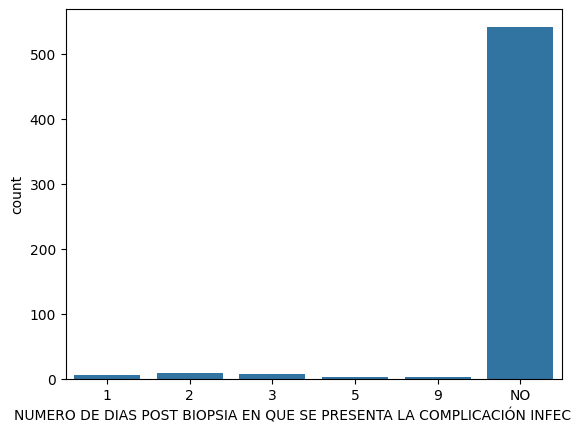

In [229]:
sns.countplot(data=df, x="NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA")

La población del tipo de cultivo no es muy significativa para este estudio.

array(['NO', 'HEMOCULTIVO', 'UROCULTIVO', 'HEMOCULTIVO Y UROCULTIVO', nan],
      dtype=object)

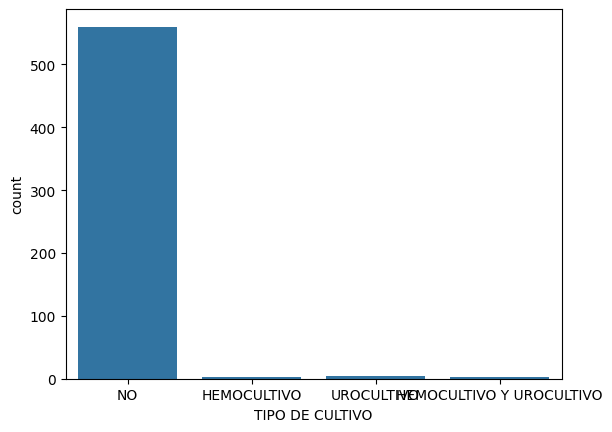

In [230]:
sns.countplot(data=df, x="TIPO DE CULTIVO")
df["TIPO DE CULTIVO"].unique()

Las personas que poseen un patron de resistencia es muy poca a comparación de la población general, sin embargo, las personas con estos patrones quedan hospitalizadas el 100% de las veces

[None, None, None, None, None, None, None, None, None, None]

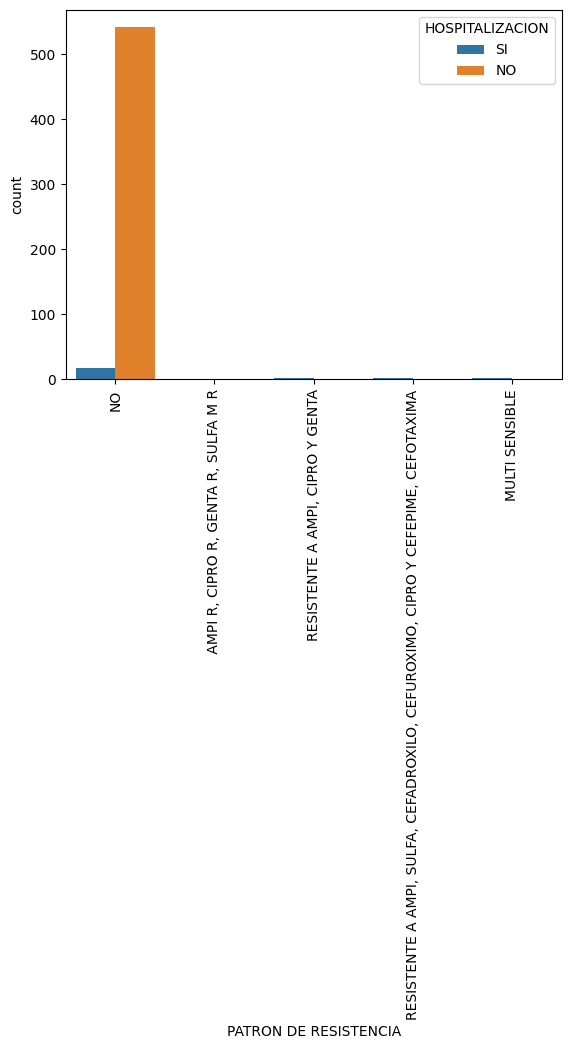

In [231]:
sns.countplot(data=df, x="PATRON DE RESISTENCIA", hue="HOSPITALIZACION")
df["TIPO DE CULTIVO"].unique()
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

# 1.4. Variables Numéricas

Los días de hospitalización MQ y UPC no tienen una población significativa. La media que presenta el PSA es muy alta por lo que hay que disminuir esos casos atípicos.

In [232]:
df.describe()

,EDAD,PSA,NUMERO DE MUESTRAS TOMADAS,DIAS HOSPITALIZACION MQ,DIAS HOSPITALIZACIÓN UPC
count,568.000000,564.000000,568.000000,568.000000,568.000000
mean,63.882042,13.271401,12.996479,0.165493,0.014085
std,9.281517,15.668966,3.921180,0.958066,0.196474
min,39.000000,0.600000,4.000000,0.000000,0.000000
25%,59.000000,5.600000,12.000000,0.000000,0.000000
50%,64.000000,8.000000,12.000000,0.000000,0.000000
75%,69.000000,15.000000,12.000000,0.000000,0.000000
max,151.000000,100.000000,24.000000,12.000000,3.000000


En la siguiente gráfica los podemos encontrar:

<Axes: ylabel='PSA'>

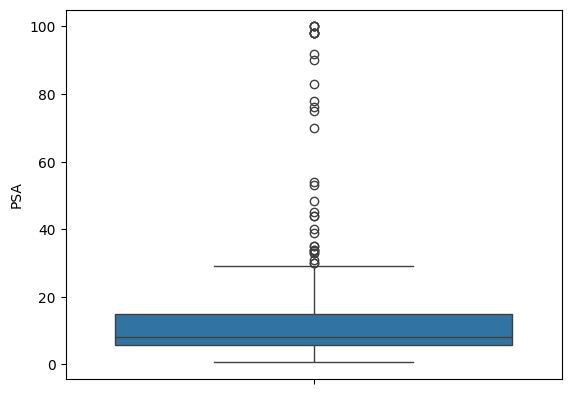

In [233]:
sns.boxplot(y=df["PSA"])

En la edad se encuentran un par de personas por encima de los 140 años lo cual no es algo normal. Tambien otra cosa a tener en cuenta sería que no existen registros para personas menores a 40 años

<Axes: ylabel='EDAD'>

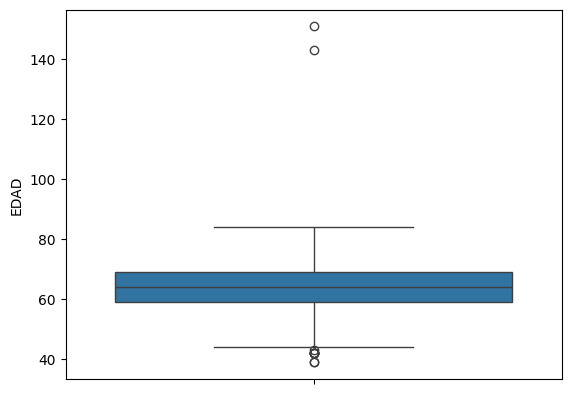

In [234]:
sns.boxplot(data = df, y="EDAD")

Conforme la edad sea más alta es más probable de que el PSA aumente, especialmente entre los 75 y 55 años, sin embargo un valor entre 0 y 10 es lo más común y puede considerarse valores "estables"

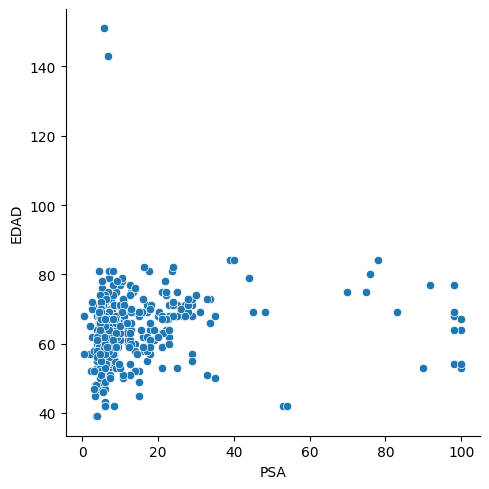

In [235]:
sns.relplot(data=df, x="PSA", y="EDAD")

#2. Transformación de Datos



Para el siguiente info() necesitamos: Número de muestras tomadas, numero de dias post biopsia en que se presenta la infección y el patrón de resistencia, asi como las variables dicotómicas a int y reemplazar los valores nulos como 0 o "No" como sea necesario. Además de eliminar las variables de menos significativas y utilizar get.dummies para el antibiotico utilizado en la profilaxis

In [236]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 20 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   EDAD                                                                       568 non-null    float64
 1   DIABETES                                                                   568 non-null    object 
 2   HOSPITALIZACIÓN ULTIMO MES                                                 568 non-null    object 
 3   PSA                                                                        564 non-null    float64
 4   BIOPSIAS PREVIAS                                                           566 non-null    object 
 5   VOLUMEN PROSTATICO                                                         567 non-null    object 
 6   ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS                   

Eliminaré las siguientes columnas

In [237]:
del df["DIAS HOSPITALIZACION MQ"]
del df["DIAS HOSPITALIZACIÓN UPC"]
del df["HOSPITALIZACIÓN ULTIMO MES"]
del df["AGENTE AISLADO"]
del df["TIPO DE CULTIVO"]

## 2.1. Convertir variables objects a enteros

Reemplazo el "NO" de número de dias post biopsia por -1 como simbólico de "no aplica", esto es porque el 0 representaria que la persona adquiere la infección el mismo día

In [238]:
df["DIABETES"] = df["DIABETES"].replace({"SI":1, "NO":0}, regex=True)
df["BIOPSIAS PREVIAS"] = df["BIOPSIAS PREVIAS"].replace({"SI":1, "NO":0}, regex=True)
df["VOLUMEN PROSTATICO"] = df["VOLUMEN PROSTATICO"].replace({"SI":1, "NO":0}, regex=True)
df["CUP"] = df["CUP"].replace({"SI":1, "NO":0}, regex=True)
df["ENF. CRONICA PULMONAR OBSTRUCTIVA"] = df["ENF. CRONICA PULMONAR OBSTRUCTIVA"].replace({"SI":1, "NO":0}, regex=True)
df["FIEBRE"] = df["FIEBRE"].replace({"SI":1, "NO":0}, regex=True)
df["ITU"] = df["ITU"].replace({"SI":1, "NO":0}, regex=True)
df["HOSPITALIZACION"] = df["HOSPITALIZACION"].replace({"SI":1, "NO":0}, regex=True)
df["NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA"] = df["NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA"].replace({"NO": -1}, regex=True)
df["NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA"] = df["NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA"].astype("float")

## 2.2. Variables Dummies

In [239]:
df = pd.get_dummies(df, columns=['ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS'])
df = pd.get_dummies(df, columns=['PATRON DE RESISTENCIA'])
df = pd.get_dummies(df, columns=['BIOPSIA'])

In [240]:
df.head()

,EDAD,DIABETES,PSA,BIOPSIAS PREVIAS,VOLUMEN PROSTATICO,NUMERO DE MUESTRAS TOMADAS,CUP,ENF. CRONICA PULMONAR OBSTRUCTIVA,NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA,FIEBRE,...,BIOPSIA_ADENOCARCINOMA GLEASON 6,BIOPSIA_ADENOCARCINOMA GLEASON 6,BIOPSIA_ADENOCARCINOMA GLEASON 7,BIOPSIA_ADENOCARCINOMA GLEASON 7,BIOPSIA_ADENOCARCINOMA GLEASON 8,BIOPSIA_ADENOCARCINOMA GLEASON 9,BIOPSIA_CARCINOMA INDIFERENCIADO DE CELULAS CLARAS,BIOPSIA_HIPERPLASIA PROSTATICA,BIOPSIA_NEG,BIOPSIA_PROSTATITIS
0,53.0,0.0,4.0,0.0,1.0,12.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,1,0
1,56.0,0.0,7.7,0.0,1.0,12.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,1,0
2,57.0,0.0,29.0,1.0,1.0,24.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,1,0
3,56.0,0.0,7.0,0.0,1.0,12.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,1,0
4,55.0,0.0,29.0,1.0,1.0,24.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,1,0


## 2.3. Llenar nulos

In [241]:
df.fillna(0, inplace = True)

## 2.4. Eliminar los registros atípicos

In [242]:
df = df[(df["PSA"] < 40)]
df = df[(df["EDAD"] < 90)]

#3. Modelamiento

Una vez hecho las transformaciones correspondientes y teniendo nuestro dataset depurado, nos toca la dividir en entrenamiento y evaluación los datos. Para ello primero necesitamos a "X" y a "y"

**Cabe recalcar que se usará el modelo XGBOOST para poder clasificar nuestros registros. XGBoost es la abreviatura de las palabras inglesas "extreme gradient boosting" (refuerzo de gradientes extremo). Este método se basa en árboles de decisión y supone una mejora sobre otros métodos, como el bosque aleatorio y refuerzo de gradientes.**

## 3.1. División de los datos

Separamos la variable objetivo de las demás variables

In [243]:
feature_cols = list(df.columns)
feature_cols.remove("HOSPITALIZACION")
X = df[feature_cols]
y = df["HOSPITALIZACION"]

Hacemos una partición para los respectivos datos y utilizamos "stratify" para distribuirlos equitativamente

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

##3.2. Optimización usando GridSearch

En la siguiente linea de código establecemos los parámetros a optimizar

In [245]:
parameters = {'max_depth': range (2, 10, 1) #La maxima profundidad del arbol
,'n_estimators': range(60, 220, 40) #El numero máximo de rondas usadas en la construcción del modelo
,'learning_rate': [0.1, 0.01, 0.05] #Controla el peso de los arboles agregados al modelo
,"eta": [0.1, 0.5, 1] #Previene el sobreajuste
              }

Creamos un modelo preliminar para evaluar su rendimiento con GridSearch

In [246]:
clf = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', silent=True, nthread=1)

Usamos GridSearch para estimar los mejores valores de hiperparámetros según la curva ROC (Receiver Operating Characteristic)

In [247]:
grid_search = GridSearchCV(estimator=clf,param_grid=parameters,scoring = 'roc_auc',n_jobs = 10,cv = 10,verbose=True)
grid_search.fit(X, y)

grid_search.best_estimator_

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:57:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=60,
              n_jobs=None, nthread=1, ...)

## 3.3 Modelamos con los hiperparametros obtenidos

In [248]:
clf2 = xgb.XGBClassifier(learning_rate=0.1 , max_depth=2, n_estimators=60, eta = 0.1, objective='binary:logistic')
clf2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=60,
              n_jobs=None, num_parallel_tree=None, ...)

Grafico del modelo:

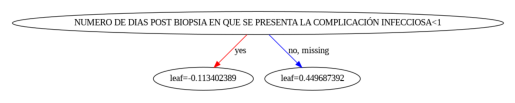

In [249]:
plot_tree(clf2)
plt.show()

#4. Evaluación

#4.1. Matriz de confusión

Aqui podremos ver la correlación entre los valores predichos y los valores reales

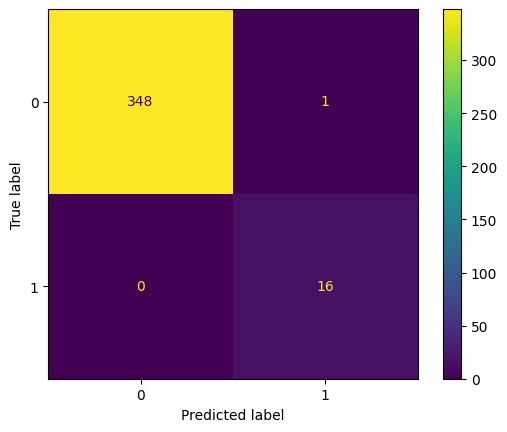

In [250]:
y_pred = clf2.predict(X_train)
cm = confusion_matrix(y_train, y_pred, labels= clf2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= clf2.classes_)
disp.plot()
plt.show()

# 4.2. Métricas

De las siguientes metricas podemos concluir: El modelo tiene un 100% de clasificar los casos positivos reales y además un 94% de no equivocarse. No podemos decir mucho de la exactitud debido al desbalance en los datos, pero según la metrica existe un 99.7% aproximación a los resultados verdaderos o conocidos.

In [251]:
print(accuracy_score(y_train, y_pred))
print(recall_score(y_train, y_pred))
print(precision_score(y_train, y_pred))

0.9972602739726028
1.0
0.9411764705882353
